In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

Defining a simple model for Y given X. True model is a 3rd degree polynomial (plus noise)

In [2]:
def EofY(x):
    return (x-10)**3/1000

variance=0.01
def Y(x):
    return EofY(x)+np.random.normal(loc=0,scale=np.sqrt(variance))

In [3]:
# For each x in xrange sample 'numsamples' many values Y(x)
# 
# Return as data instance feature vector x,x^2,...,x^p and label Y(x)
# Also return a matrix containing the p-tuples of input feature values

def sampdata(xrange,numsamples,p): 
    #data=np.zeros((len(xrange)*numsamples,p+1)) 
    inputfeats=np.zeros((len(xrange),p))
    data=[]
    
    for i,x in enumerate(xrange):
        for j in range(p):
            inputfeats[i,j]=xrange[i]**(j+1)
        for j in range(numsamples):
            instance=np.zeros(p+1)
            instance[0:p]=inputfeats[i,:]
            instance[p]=Y(x)
            data.append(instance)
    inputfeats=inputfeats.reshape(-1,p)
    return np.array(data),inputfeats


Illustration of a data sample and the ideal regression curve E[Y|X] = EofT(x)

In [4]:
# Parameters for sampling:
    
xrange=np.arange(0,20,0.1)
numsamples=7
p=4


data,inputfeats=sampdata(xrange,numsamples,p)

data is an (len(xrange)*numsamples) x (p+1) dimensional matrix.  The rows are blocks of size numsamples for each point in xrange.  The first p columns are the corresponding feature values, and the last column the sampled y value. inputfeats is a len(range)xp dimensional matrix just containing the feature values at the points of xrange.

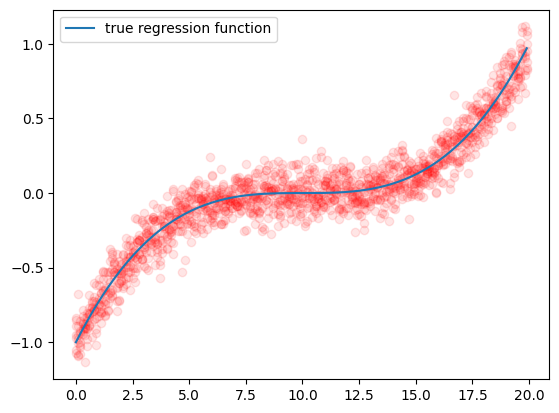

In [5]:
EOY=np.vectorize(EofY)(xrange)
plt.plot(xrange,EOY,label="true regression function")
plt.scatter(data[:,0],data[:,p],c='red',alpha=0.1)
plt.legend()
plt.show()

### Expected loss decomposition

Plot learned linear regression model over feature vectors x,x^2,...,x^p for p=1,2,3,4 (for p=3 and p=4 the optimal function E[Y|x] is in the hypothesis space):

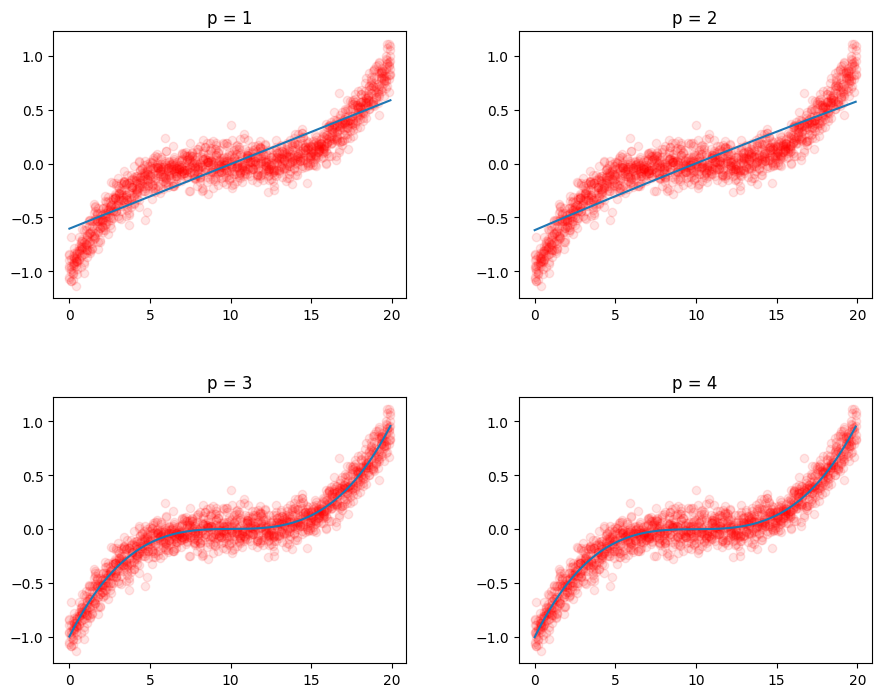

In [6]:

models=[]
fig,axes = plt.subplots(2,2,figsize=(10,8))
fig.tight_layout(pad=5.0)


for i in range(p):
    model=LinearRegression().fit(data[:,0:i+1],data[:,-1])
    models.append(model)
    preds=model.predict(inputfeats[:,0:i+1])
    axes.ravel()[i].scatter(data[:,0],data[:,4],c='red',alpha=0.1)
    axes.ravel()[i].plot(xrange,preds,label="p= {}".format(i+1))
    axes.ravel()[i].set_title("p = {}".format(i+1))
 
plt.show()

Decomposing the error: calculate for each x an estimation of the expected error by the empirical error (black curves) and the inherent model error (red curves). The difference between the two is equal to the variance specified in the Y|X model (for all x)

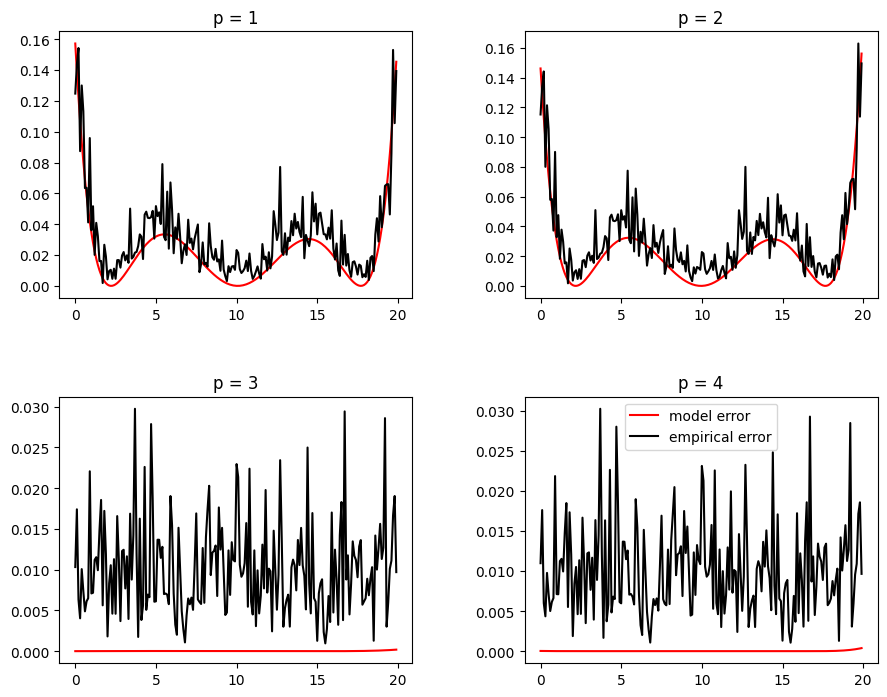

In [7]:
fig,axes = plt.subplots(2,2,figsize=(10,8))
fig.tight_layout(pad=5.0)

datareduce=data[:,p].reshape((len(xrange),numsamples))

for i in range(p):
    #model predictions:
    pred=models[i].predict(inputfeats[:,0:i+1])
    #squared errors:    
    errors=np.zeros(len(xrange))
    for j in range(numsamples):
        errors+=(pred-datareduce[:,j])**2
    errors/=numsamples    
    axes.ravel()[i].plot(xrange,(pred-EOY)**2,label="model error",c='red')
    axes.ravel()[i].plot(xrange,errors,label="empirical error",c='black')
#     axright=axes.ravel()[i].twinx()
#     axright.plot(xrange,np.ones(len(xrange)),label="noise")
    axes.ravel()[i].set_title("p = {}".format(i+1))

plt.legend()
plt.show()

**Exercise:** Consider other types of regression models with varying complexities of their hypothesis spaces (using only x, not the higher order terms, as input feature). Plot model error and empirical error, and verify that the difference is (approximately) equal to the variance. Check the effect of increasing the variance in the data generator. 

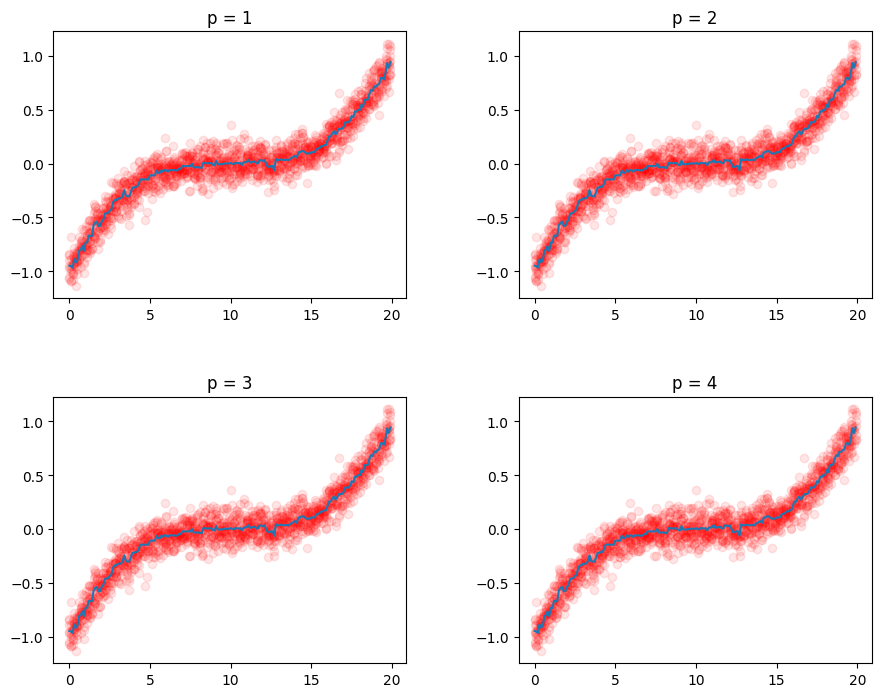

In [8]:
models=[]
fig,axes = plt.subplots(2,2,figsize=(10,8))
fig.tight_layout(pad=5.0)


for i in range(p):
    model=GradientBoostingRegressor().fit(data[:,0:i+1],data[:,-1])
    models.append(model)
    preds=model.predict(inputfeats[:,0:i+1])
    axes.ravel()[i].scatter(data[:,0],data[:,4],c='red',alpha=0.1)
    axes.ravel()[i].plot(xrange,preds,label="p= {}".format(i+1))
    axes.ravel()[i].set_title("p = {}".format(i+1))
 
plt.show()

0.008665011308855532
0.008665011308855532
0.008665011308855532
0.008665011308855532


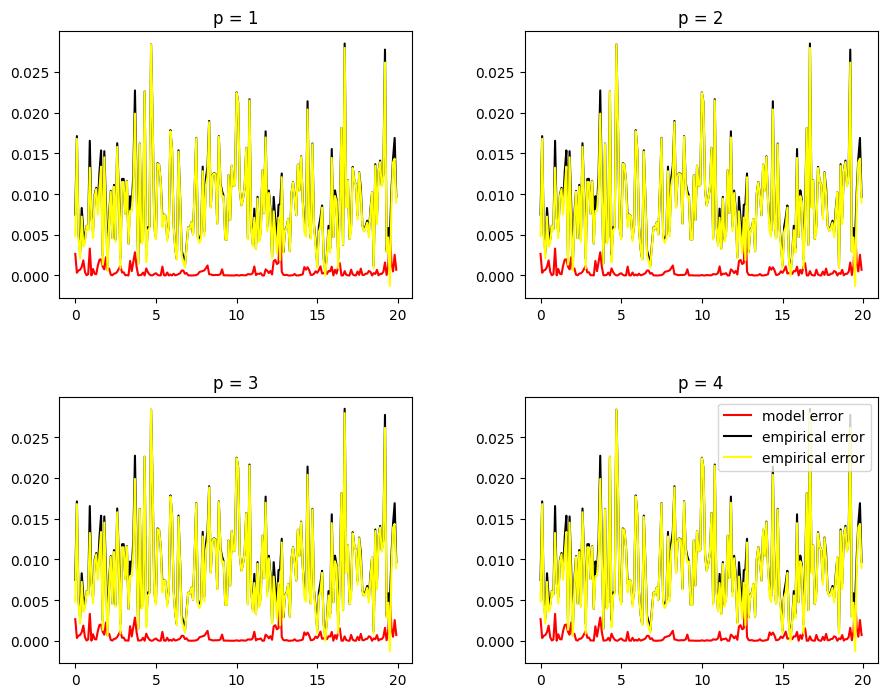

In [9]:
fig,axes = plt.subplots(2,2,figsize=(10,8))
fig.tight_layout(pad=5.0)

datareduce=data[:,p].reshape((len(xrange),numsamples))

for i in range(p):
    #model predictions:
    pred=models[i].predict(inputfeats[:,0:i+1])
    #squared errors:    
    errors=np.zeros(len(xrange))
    for j in range(numsamples):
        errors+=(pred-datareduce[:,j])**2
    errors/=numsamples    
    axes.ravel()[i].plot(xrange,(pred-EOY)**2,label="model error",c='red')
    axes.ravel()[i].plot(xrange,errors,label="empirical error",c='black')
    axes.ravel()[i].plot(xrange,(errors - (pred-EOY)**2),label="empirical error",c='yellow')
    print(np.mean(errors - (pred-EOY)**2))
#     axright=axes.ravel()[i].twinx()
#     axright.plot(xrange,np.ones(len(xrange)),label="noise")
    axes.ravel()[i].set_title("p = {}".format(i+1))

plt.legend()
plt.show()

### Bias-variance decomposition

Sample multiple small datasets:

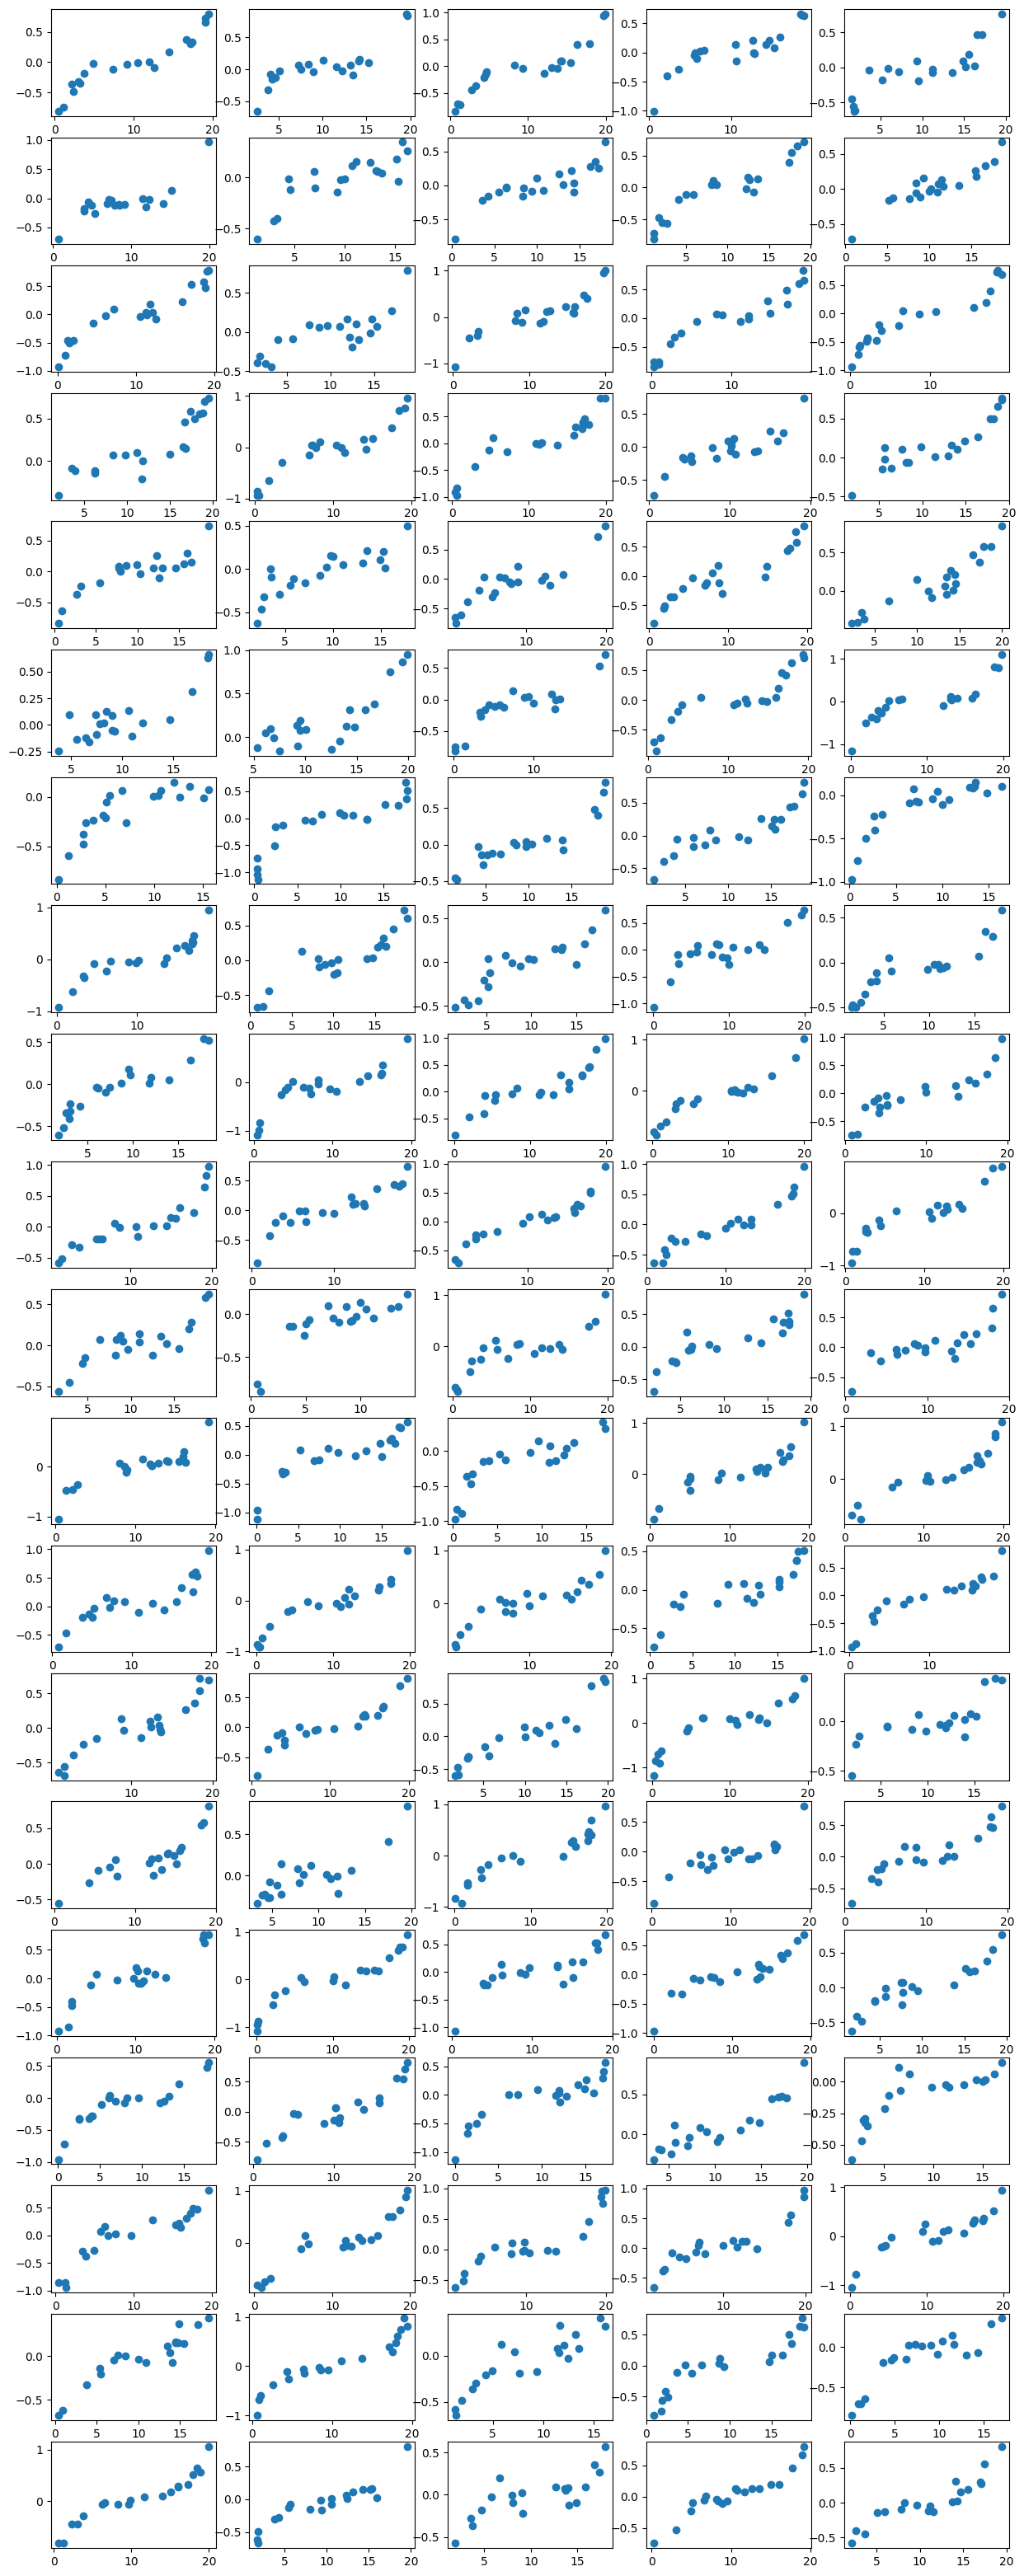

In [10]:

numdatasets=100
numpoints=20
p=4

datasets=[]
numrows=int(numdatasets/5)
fig,axes = plt.subplots(numrows,5,figsize=(15,2*numrows))


for i in range(numdatasets):
    # This time we generate a random set of x-values, and only one Y for each x.
    xvals=20*np.random.random(numpoints)
    D=sampdata(xvals,1,p)[0]
    datasets.append(D)
    axes.ravel()[i].scatter(D[:,0],D[:,p])
    
plt.show()


Training models on each dataset:

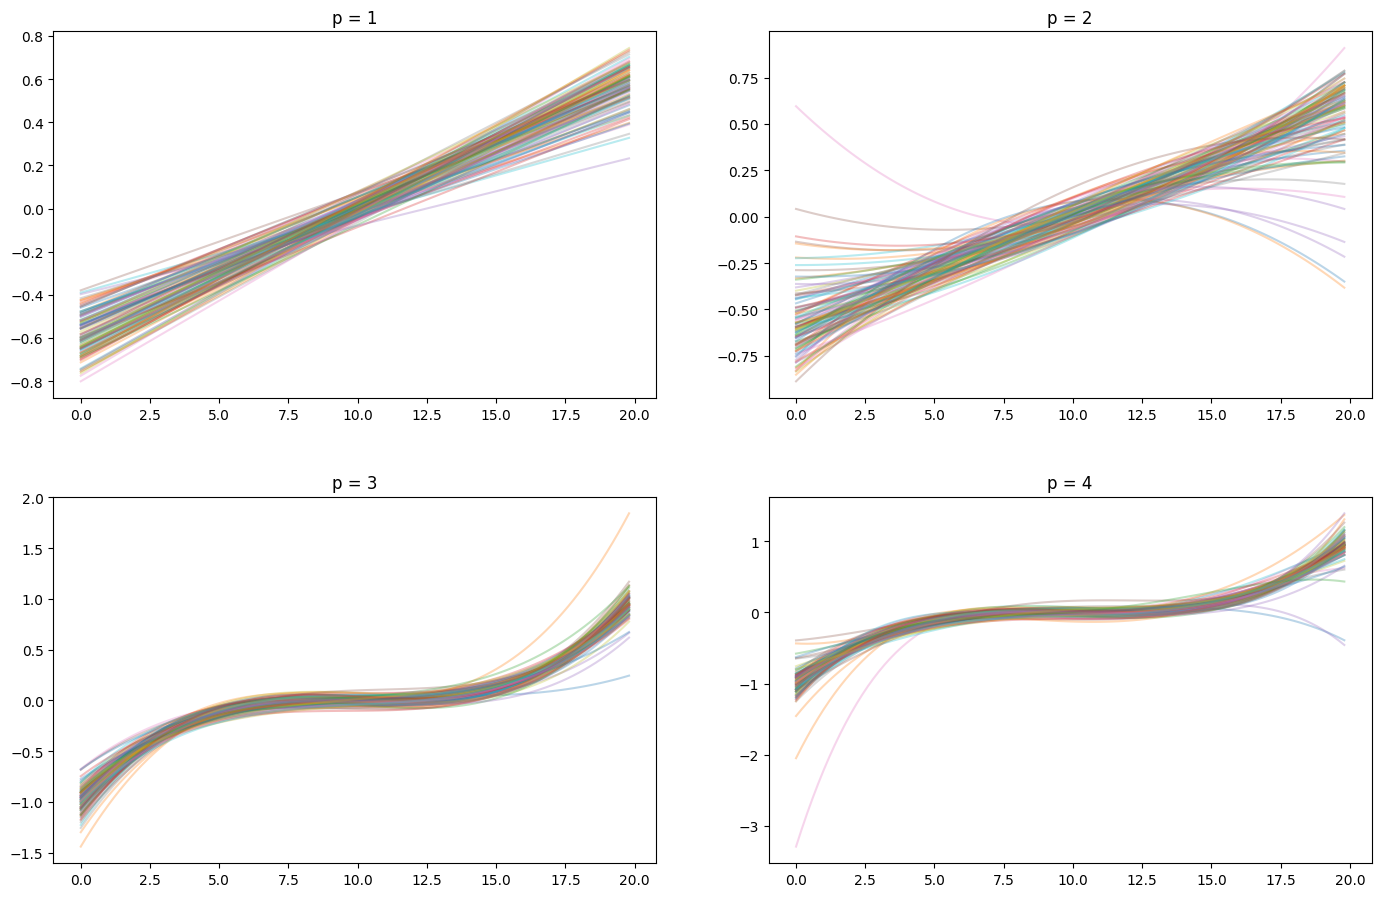

In [11]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
fig.tight_layout(pad=5.0)


_,xforplot= sampdata(np.arange(0,20,0.2),1,p) # for plotting the learned regression functions \hat{y}

allmodels = []
hatys = []

for j in range(p):
    jmodels = []
    jhatys = []
    for i in range(numdatasets):
        model=LinearRegression().fit(datasets[i][:,0:j+1],datasets[i][:,-1])
        jmodels.append(model)
        haty=model.predict(xforplot[:,0:j+1])
        jhatys.append(haty)
        axes.ravel()[j].plot(xforplot[:,0],haty,alpha=0.3)
        
        axes.ravel()[j].set_title("p = {}".format(j+1))  
    allmodels.append(jmodels)
    hatys.append(jhatys)
        
plt.show()        
    


Construct the bias variance decomposition

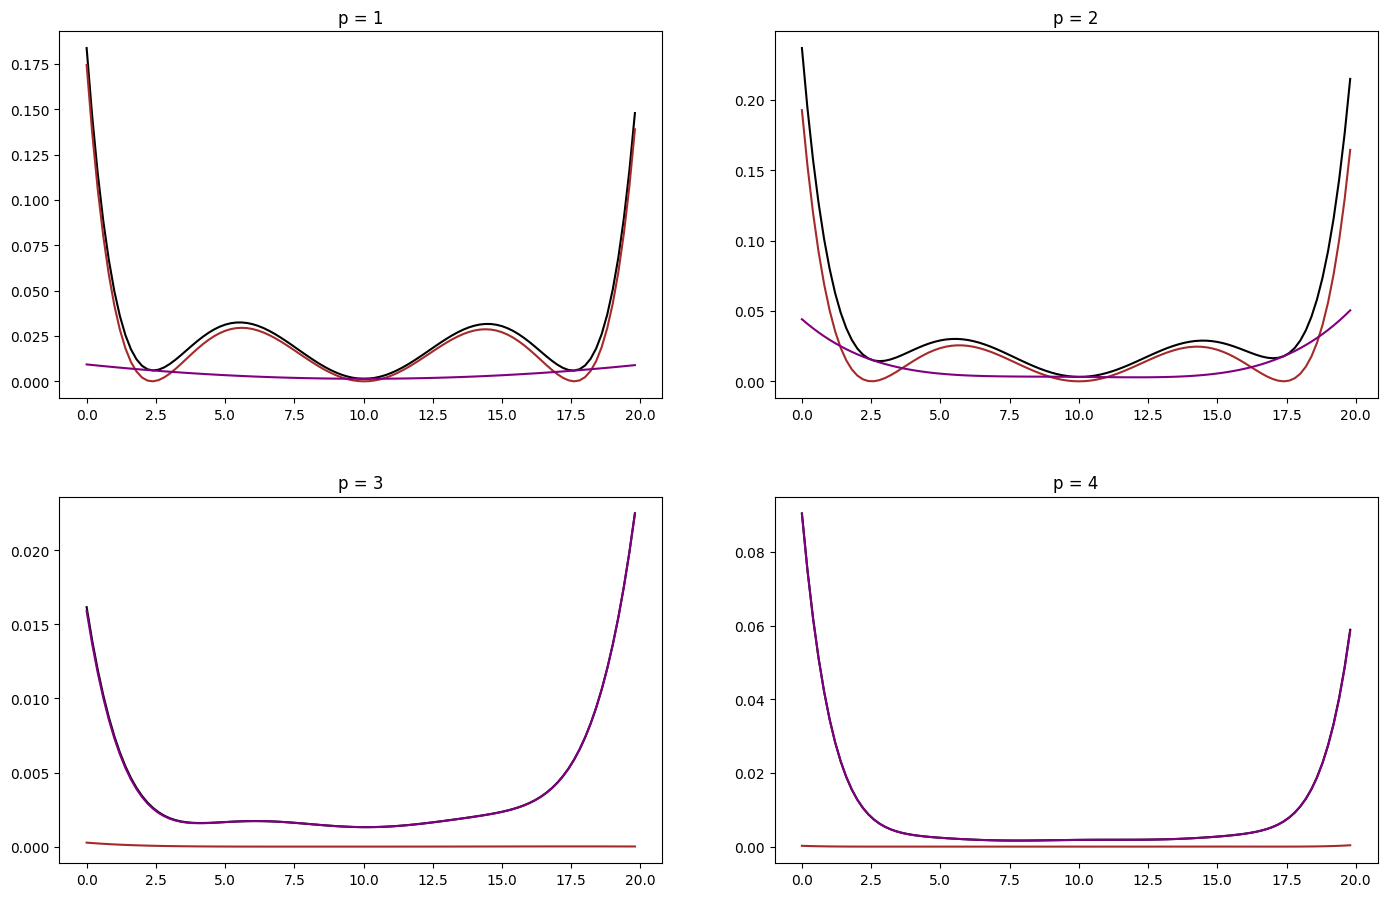

In [12]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
fig.tight_layout(pad=5.0)

EOY=np.vectorize(EofY)(xforplot[:,0])

for j in range(p):
    # calculate E_D[\hat{y}_D(x)-E[Y|x]]:
    ED=np.zeros(xforplot.shape[0])
    B=np.zeros(xforplot.shape[0])
    V=np.zeros(xforplot.shape[0])
    EhatY=np.zeros(xforplot.shape[0])
    
    for d in range(numdatasets):
        ED+=(hatys[j][d]-EOY)**2
        EhatY+=hatys[j][d]
        B+=hatys[j][d]
    
    
    ED/=numdatasets
    EhatY/=numdatasets
    B=(EhatY-EOY)**2
    
    for d in range(numdatasets):
        V+=(hatys[j][d]-EhatY)**2
    V/=numdatasets
    
    axes.ravel()[j].plot(xforplot[:,0],ED,c='black')
    axes.ravel()[j].plot(xforplot[:,0],B,c='brown')
    axes.ravel()[j].plot(xforplot[:,0],V,c='purple')
    
    axes.ravel()[j].set_title("p = {}".format(j+1))  
    
    
plt.show()


For the underfitting models p=1,2 the expected model error (black) is almost entirely due to bias (brown). For the 'fitting' models p=3,4 it is almost entirely due to variance (purple). 

**Exercise:** the equality 

model error = bias^2 + variance

does not hold precisely in all the plots above. Check how big the deviations from this equality are, and whether they are reduced by performing the calculations based on a larger number of datasets. 

0.021605398590982386
0.021822519917311968
2.5424127691847133e-05
2.3758439106104368e-05


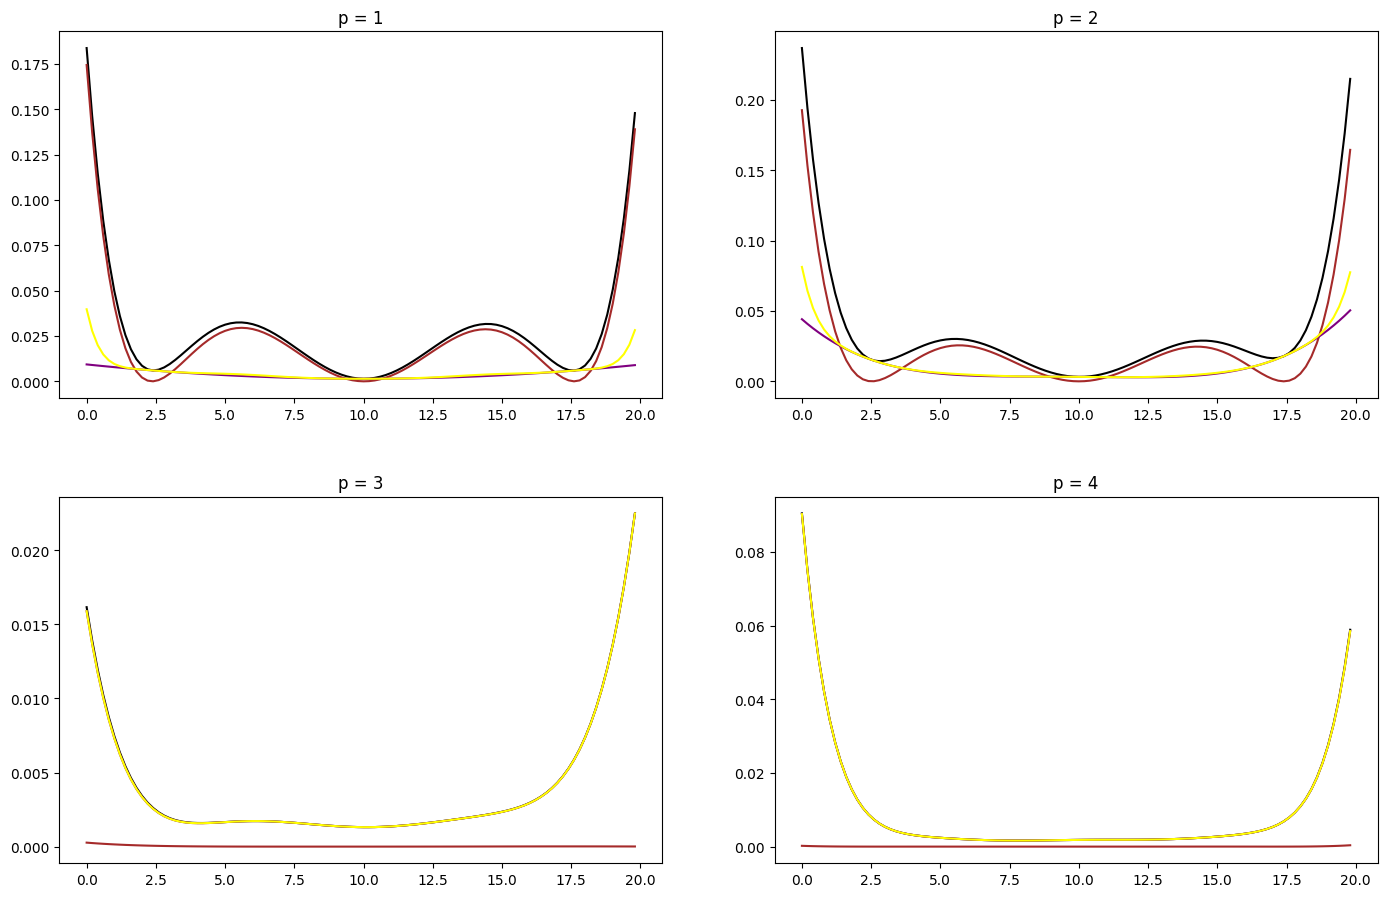

In [13]:
fig,axes=plt.subplots(2,2,figsize=(15,10))
fig.tight_layout(pad=5.0)

EOY=np.vectorize(EofY)(xforplot[:,0])

for j in range(p):
    # calculate E_D[\hat{y}_D(x)-E[Y|x]]:
    ED=np.zeros(xforplot.shape[0])
    B=np.zeros(xforplot.shape[0])
    V=np.zeros(xforplot.shape[0])
    EhatY=np.zeros(xforplot.shape[0])
    
    for d in range(numdatasets):
        ED+=(hatys[j][d]-EOY)**2
        EhatY+=hatys[j][d]
        B+=hatys[j][d]
    
    
    ED/=numdatasets
    EhatY/=numdatasets
    B=(EhatY-EOY)**2
    
    for d in range(numdatasets):
        V+=(hatys[j][d]-EhatY)**2
    V/=numdatasets
    
    axes.ravel()[j].plot(xforplot[:,0],ED,c='black')
    axes.ravel()[j].plot(xforplot[:,0],B,c='brown')
    axes.ravel()[j].plot(xforplot[:,0],V,c='purple')
    axes.ravel()[j].plot(xforplot[:,0],(B**2 + V),c='yellow')
    print(np.mean(ED) - np.mean(B**2 + V))
    
    axes.ravel()[j].set_title("p = {}".format(j+1))  
    
    
plt.show()


**Exercise:** check how the model error, bias and variance behave as a function of the 'numpoints' parameter (size of the individual datasets).

### Committee

We consider the committee consisting of all the p=degree models learned from different datasets:

In [14]:
degree=1
committee = allmodels[degree-1]

Computing the error functions:

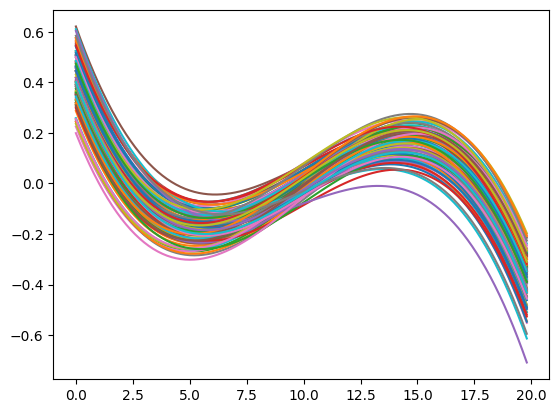

In [15]:
EOY=np.vectorize(EofY)(xforplot[:,0])

allpredictions=np.zeros((len(committee),len(xforplot[:,0])))
allerrors=np.zeros((len(committee),len(xforplot[:,0])))

for m in range(len(committee)):
    allpredictions[m,:]=committee[m].predict(xforplot[:,0:degree])
    allerrors[m,:]=allpredictions[m,:]-EOY
    plt.plot(xforplot[:,0],allerrors[m,:])
    
plt.show()    
    

Looking at the distribution (over models) of the expected errors:

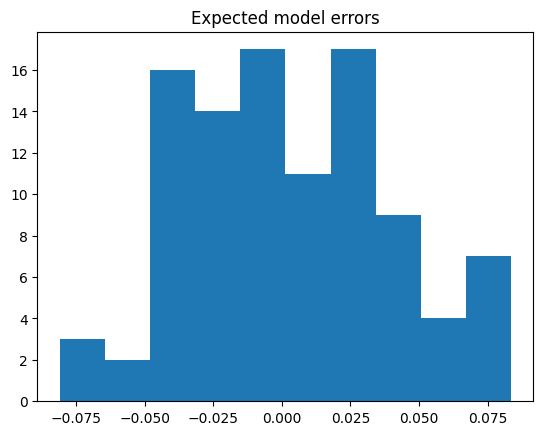

In [16]:
Eerrors = np.mean(allerrors,axis=1)

plt.hist(Eerrors)
plt.title("Expected model errors")
plt.show()

Assumption A1 is not too far off!  Now looking at the correlation of all pairs of models:

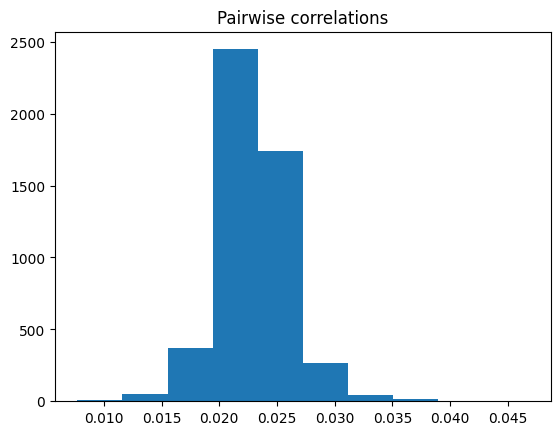

In [17]:
correlations = []
for m in range(len(committee)-1):
    for l in range(m+1,len(committee)):
        correlations.append( np.mean(allerrors[m,:]*allerrors[l,:] ) )
        
plt.hist(correlations)  
plt.title('Pairwise correlations')
plt.show()

Errors are positively correlated!  Now compare the squared committee error with the average model error:

In [18]:
squarederrors = np.mean(allerrors**2,axis=1)

print("Mean squared error of the members of the committee: {}".format(np.mean(squarederrors)))

pred_com=np.mean(allpredictions,axis=0)

squared_error_com = np.mean((pred_com-EOY)**2)

print("Squared error of the committee: {}".format(squared_error_com))


Mean squared error of the members of the committee: 0.02707178645858707
Squared error of the committee: 0.023032998235615137


Squared error of the committee only marginally lower than mean squared error of committee members.  

### AdaBoost

We load a slightly more challenging version of the separateme dataset already used in the SVM notebook:

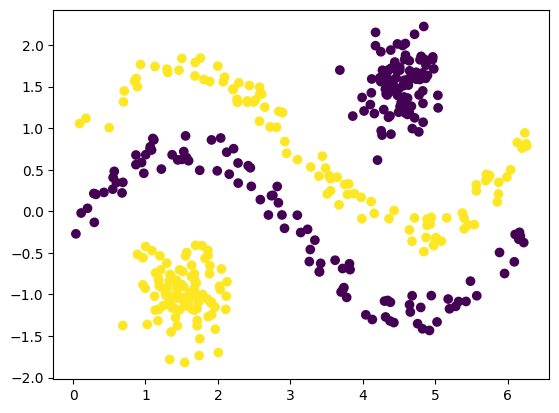

In [19]:
separateme_train=pd.read_csv("data/separateme_reloaded_train.csv")
separateme_test=pd.read_csv("data/separateme_reloaded_test.csv")


plt.scatter(separateme_train['X1'],separateme_train['X2'],c=separateme_train['Y'])
plt.show()

**Exercise (self study)**: Train the sklearn.ensemble.AdaBoostClassifier on this dataset. Increase the number of base classifiers (parameter n_estimators), and  
<ul>
    <li>
        Visualize the decision regions of the different base classifiers of the model, as well as the decision regions of the ensemble.
    </li>
    <li>
        Plot the accuracy of the model as a function of n_estimators 
        </li>
    <li>
        Vary the type of base classifiers. If you choose a simple logistic regression base classifier, how do the results compare to the default choice of DecisionTreeClassifier(max_depth=1)?
    </li>
    </ul>

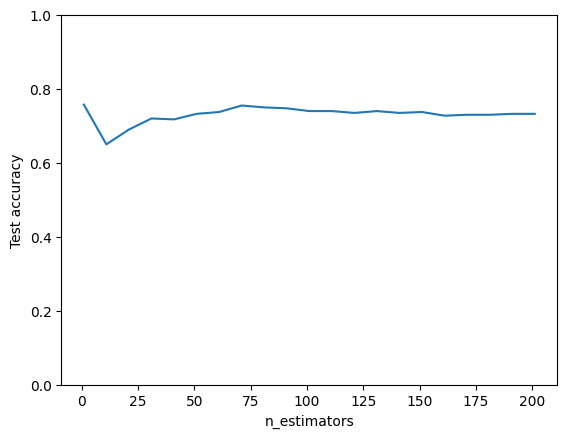

In [52]:
from sklearn.ensemble import AdaBoostClassifier

X_train=separateme_train[['X1','X2']].to_numpy()
Y_train=separateme_train[['Y']].to_numpy().ravel()

X_test=separateme_test[['X1','X2']].to_numpy()
Y_test=separateme_test[['Y']].to_numpy().ravel()

accuracy_test=[]
for n in range(1,202,10):
    model=AdaBoostClassifier(n_estimators=n).fit(X_train,Y_train)
    accuracy_test.append(model.score(X_test,Y_test))

# Plot the test accuracy as a function of n_estimators
plt.plot(range(1,202,10),accuracy_test)
plt.xlabel("n_estimators")
plt.ylabel("Test accuracy")
plt.ylim(0,1)
plt.show()

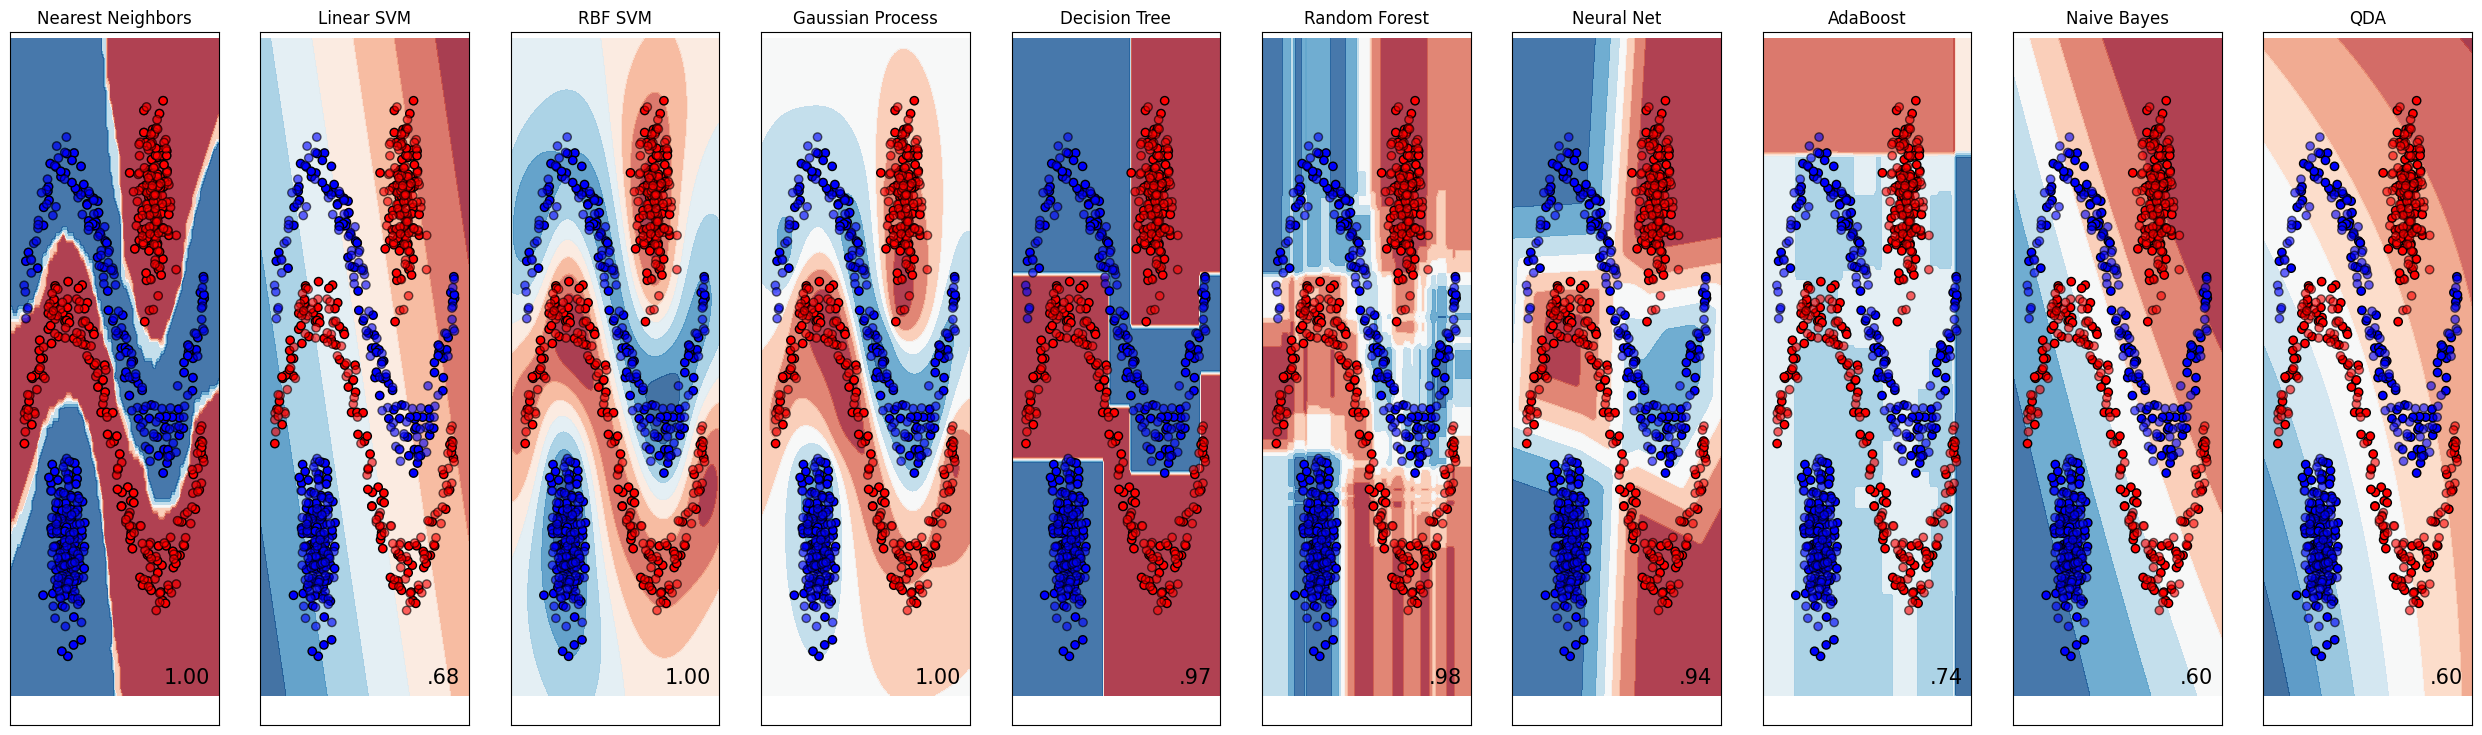

In [57]:
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

figure = plt.figure(figsize=(35, 9))
i = 1
x_min, x_max = np.min(X_train[:, 0]) - 0.5, np.max(X_train[:, 0]) + 0.5
y_min, y_max = np.min(X_train[:, 1]) - 0.5, np.max(X_train[:, 1]) + 0.5
# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#FF0000", "#0000FF"])
ax = plt.subplot(1, len(classifiers) + 1, i)
ax.set_title("Input data")
ax.scatter(X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm_bright, edgecolors="k")
# Plot the testing points
ax.scatter(
    X_test[:, 0], X_test[:, 1], c=Y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
)
ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min, y_max)
ax.set_xticks(())
ax.set_yticks(())

 # iterate over classifiers
for name, clf in zip(names, classifiers):
    ax = plt.subplot(1, len(classifiers) + 1, i)

    clf = make_pipeline(StandardScaler(), clf)
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)
    DecisionBoundaryDisplay.from_estimator(
        clf, X_test, cmap=cm, alpha=0.8, ax=ax, eps=0.5
    )

    # Plot the training points
    ax.scatter(
        X_train[:, 0], X_train[:, 1], c=Y_train, cmap=cm_bright, edgecolors="k"
    )
    # Plot the testing points
    ax.scatter(
        X_test[:, 0],
        X_test[:, 1],
        c=Y_test,
        cmap=cm_bright,
        edgecolors="k",
        alpha=0.6,
    )

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(name)
    ax.text(
        x_max - 0.3,
        y_min + 0.3,
        ("%.2f" % score).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    i+=1
